# Optimizers

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

## Bayesian Optimization

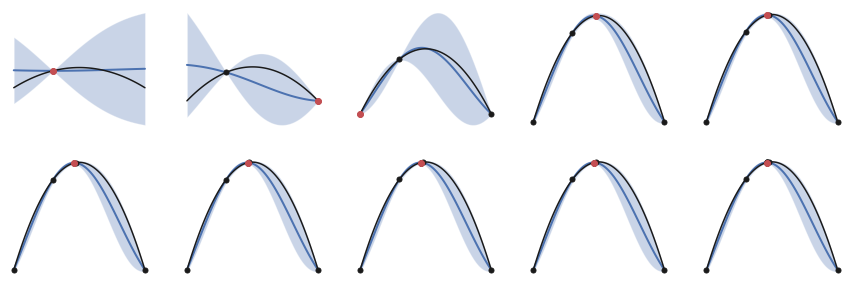

In [2]:
# Define a simple objective function
def objective(x: float) -> float:
    return -x ** 2

# Create the optimizer
bo = sia.BayesianOptimizer(lower=np.array([-1]), upper=np.array([1]))

# Plot the raw data
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
ax = ax.flat
sns.despine(f, left=True, bottom=True)

X = np.array([])
Y = np.array([])

for i in range(len(ax)):
    # Perform a step of the Bayesian optimization
    x = bo.selectNextSample()
    y = objective(x)
    bo.addDataPoint(x, y[0])
    bo.updateModel()
    
    X = np.hstack((X, x))
    Y = np.hstack((Y, y))

    # Evaluate the surrogate model
    gpr = bo.gpr()
    xtest = np.linspace(-1, 1, 101)
    ytest = objective(xtest)
    gpr_mu = np.zeros(len(xtest))
    gpr_std = np.zeros(len(xtest))
    for k in range(len(xtest)):
        gaussian = gpr.predict(np.array([xtest[k]]))
        gpr_mu[k] = gaussian.mean()[0]
        gpr_std[k] = np.sqrt(gaussian.covariance()[0, 0])
    
    # Plot the belief for each axis and overlay the training data
    ax[i].fill_between(xtest, gpr_mu + 3 * gpr_std, gpr_mu - 3 * gpr_std,  alpha=0.3)
    ax[i].plot(xtest, gpr_mu, 'b', lw=2)
    ax[i].plot(xtest, ytest, '-k')
    ax[i].plot(X, Y, '.k', ms=10)
    ax[i].plot(x, y, '.r', ms=12)
    ax[i].axis("off")